In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import functions as fx

from matplotlib import rc
from matplotlib import rcParams

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

pad = 12
rcParams['xtick.major.pad'] = pad
rcParams['ytick.major.pad'] = pad

dpi = 200

%matplotlib inline

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from galpy.orbit import Orbit
from galpy import potential

from galpy.util import bovy_conversion

In [3]:
## parameters for Crater II

gaiasys = 0.035

ra = 177.3
dec = -18.4

dist = 117.5 #distance from Torrealba+16
dist_err = 1.1

vlos = 87.6

pmra, pmra_e = -0.17, 0.06
pmdec, pmdec_e = -0.07, 0.03


# Fiducial model of Cra II orbit

In [4]:
#parameterizing MW halo using params from McMillan 2017

c = 1.0
ro = 8.2
vo = 232.8

tp_amp= potential.TriaxialNFWPotential(amp=1.,a=2.,c=c)
mvir= tp_amp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12. 
print(mvir)
# mass out to ~245 kpc in units of 10^12 Msun, for non-spherical potential need to give R and z max to integrate

tp= potential.TriaxialNFWPotential(amp=1.3/mvir,a=2.,c=c)
# amp = (0.8 x 10^12 Msun: desired mass) / (mvir x 10^12: mass for amp=1)
print(tp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12.) # Should be the mass you want

bp= potential.PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/ro,normalize=0.05) 
mp= potential.MiyamotoNagaiPotential(a=3./ro,b=0.28/ro,normalize=.6)

pot_fid = [tp, bp, mp]

0.2001449702847074
1.3000000001287741


In [8]:
ts_small = np.linspace(0,2.5,5000)*u.Gyr

fid = Orbit([ra*u.degree,
            dec*u.degree,
            dist*u.kpc,
            pmra*u.mas/u.yr,
            pmdec*u.mas/u.yr,
            vlos*u.km/u.s],
            radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

fid_flip = fid.flip() 
fid_flip.integrate(ts_small,pot_fid)
fid_flip.flip(inplace=True)
fid.integrate(ts_small,pot_fid)

In [6]:
minix = np.argmin(fid_flip.r(ts_small)) 
print('In fiducial model from McMillan 2017, Cra II made pericentric passage ' + 
      ("%.2f" % ts_small[minix].value) + ' Gyr ago, approaching ' + ("%.2f" % fid_flip.r(ts_small)[minix]) + 
      ' kpc of the Milky Way Center.')

In fiducial model from McMillan 2017, Cra II made pericentric passage 1.49 Gyr ago, approaching 33.35 kpc of the Milky Way Center.


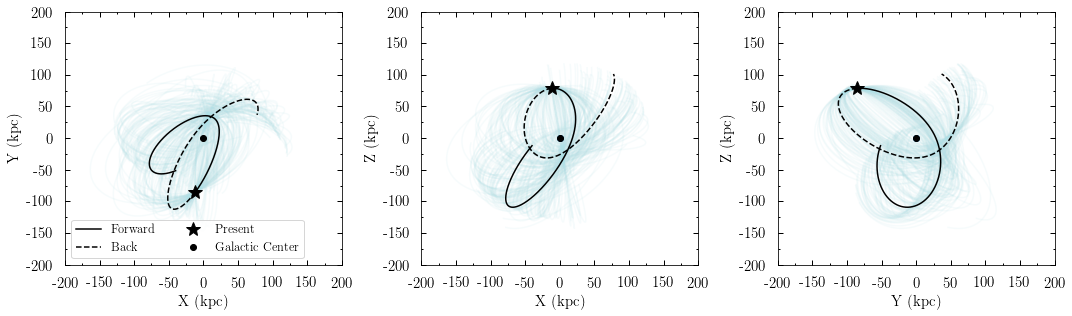

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15,4.5))

np.random.seed(4747)

plot_sampsize = 100

pmra_plot = np.random.normal(pmra, np.sqrt(np.square(pmra_e) + np.square(gaiasys)),plot_sampsize)
pmde_plot = np.random.normal(pmdec, np.sqrt(np.square(pmdec_e) + np.square(gaiasys)), plot_sampsize)

for k in range(plot_sampsize):
    orb = Orbit([ra*u.degree,
            dec*u.degree,
            dist*u.kpc,
            pmra_plot[k]*u.mas/u.yr,
            pmde_plot[k]*u.mas/u.yr,
            vlos*u.km/u.s],
            radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

    orb_flip = orb.flip() 
    orb_flip.integrate(ts_small,pot_fid)
    orb_flip.flip(inplace=True)
    orb.integrate(ts_small,pot_fid)
    
    ax[0].plot(orb_flip.x(ts_small), orb_flip.y(ts_small),ls='-',color='powderblue',alpha=0.1)
    ax[1].plot(orb_flip.x(ts_small), orb_flip.z(ts_small),ls='-',color='powderblue',alpha=0.1)
    ax[2].plot(orb_flip.y(ts_small), orb_flip.z(ts_small),ls='-',color='powderblue',alpha=0.1)

    ax[0].plot(orb.x(ts_small), orb.y(ts_small),ls='-',color='powderblue',alpha=0.1)
    ax[1].plot(orb.x(ts_small), orb.z(ts_small),ls='-',color='powderblue',alpha=0.1)
    ax[2].plot(orb.y(ts_small), orb.z(ts_small),ls='-',color='powderblue',alpha=0.1)

ax[0].plot(fid.x(ts_small),fid.y(ts_small),color='black',ls='-',label='Forward',zorder=1000)
ax[0].plot(fid_flip.x(ts_small),fid_flip.y(ts_small),color='black',ls='--',label='Back',zorder=1000)
ax[0].plot(fid_flip.x(ts_small)[0],fid_flip.y(ts_small)[0],color='black',ls='None',label='Present',
           markersize=15,marker='*',zorder=1000)
ax[0].set_xlabel('X (kpc)',fontsize=15)
ax[0].set_ylabel('Y (kpc)',fontsize=15)

ax[1].plot(fid.x(ts_small),fid.z(ts_small),color='black',ls='-',zorder=1000)
ax[1].plot(fid_flip.x(ts_small),fid_flip.z(ts_small),color='black',ls='--',zorder=1000)
ax[1].plot(fid_flip.x(ts_small)[0],fid_flip.z(ts_small)[0],color='black',ls='None',label='Present',
           markersize=15,marker='*',zorder=1000)
ax[1].set_xlabel('X (kpc)',fontsize=15)
ax[1].set_ylabel('Z (kpc)',fontsize=15)
ax[1].plot(0,0,marker='o',ls='None')


ax[2].plot(fid.y(ts_small),fid.z(ts_small),color='black',ls='-',zorder=1000)
ax[2].plot(fid_flip.y(ts_small),fid_flip.z(ts_small),color='black',ls='--',zorder=1000)
ax[2].plot(fid_flip.y(ts_small)[0],fid_flip.z(ts_small)[0],color='black',ls='None',label='Present',
           markersize=15,marker='*',zorder=1000)
ax[2].set_xlabel('Y (kpc)',fontsize=15)
ax[2].set_ylabel('Z (kpc)',fontsize=15)
ax[2].plot(0,0,marker='o',ls='None')


major_tick_length = 5
major_tick_width = 1
minor_tick_length = 2
minor_tick_width = 1

for i in range(3):
    ax[i].set_xlim(-200,200)
    ax[i].set_ylim(-200,200)
    ax[i].plot(0,0,marker='o',ls='None',label='Galactic Center',color='black')    
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(25))

    ax[i].yaxis.set_major_locator(MultipleLocator(50))
    ax[i].yaxis.set_minor_locator(MultipleLocator(25))

    ax[i].set_xticklabels(np.round(np.arange(-250,250,50),0),fontsize=15)
    ax[i].set_yticklabels(np.round(np.arange(-250,250,50),0),fontsize=15)

    ax[i].tick_params(axis='both',direction='in',bottom='on',top='on',right='on',left='on',which='major',
                 length = major_tick_length, width = major_tick_width)
    ax[i].tick_params(axis='both',direction='in',bottom='on',top='on',right='on',left='on',which='minor',
                  length = minor_tick_length, width = minor_tick_width)

ax[0].legend(fontsize=12.5,loc='lower left',ncol=2)

fig.tight_layout()

# fig.savefig('CraII_fiducial_M17.pdf',bbox_inches='tight',dpi=dpi)

# Testing effects of halo flattening on fiducial pericenter distance

In [9]:
ts_small = np.linspace(0,5,5000)*u.Gyr

c_grid = np.array([0.5,0.6,0.7,0.8,0.9,1.0]) 

orb_forward = []
orb_backward = []
        
for i in range(c_grid.size):
    tp_amp= potential.TriaxialNFWPotential(amp=1.,a=2.,c=c_grid[i])
    mvir= tp_amp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12. 
    
    tp= potential.TriaxialNFWPotential(amp=1.3/mvir,a=2.,c=c_grid[i]) 
    print('Mass of Halo: ' + np.str(np.round(tp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12., 2)) + ' 10^12 Solar masses')

    pot = [tp,bp,mp]
    orb = Orbit([ra*u.degree,
                dec*u.degree,
                dist*u.kpc,
                pmra*u.mas/u.yr,
                pmdec*u.mas/u.yr,
                vlos*u.km/u.s],
            radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

    orb_flip = orb.flip() 
    orb_flip.integrate(ts_small,pot)
    orb_flip.flip(inplace=True)
    orb.integrate(ts_small,pot)
    
    orb_forward.append(orb)
    orb_backward.append(orb_flip)

Mass of Halo: 1.3 10^12 Solar masses
Mass of Halo: 1.3 10^12 Solar masses
Mass of Halo: 1.3 10^12 Solar masses
Mass of Halo: 1.3 10^12 Solar masses
Mass of Halo: 1.3 10^12 Solar masses
Mass of Halo: 1.3 10^12 Solar masses


(array([29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5, 34. ]),
 <a list of 11 Text yticklabel objects>)

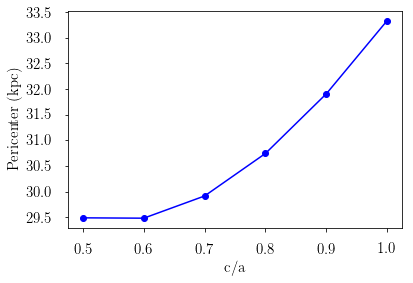

In [10]:
peri = np.array([orb_backward[0].rperi(),orb_backward[1].rperi(),orb_backward[2].rperi(),
       orb_backward[3].rperi(),orb_backward[4].rperi(),orb_backward[5].rperi()])

plt.plot(c_grid,peri,marker='o',color='blue')
plt.xlabel('c/a',fontsize=15)
plt.ylabel('Pericenter (kpc)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Reading in the results of the MC

In [11]:
# these are the arrays used to generate the samples of the MCMC

np.random.seed(4747)

sampsize=5000

dist_ar = np.random.normal(dist, dist_err, sampsize)
pmra_ar = np.random.normal(pmra, np.sqrt(np.square(pmra_e) + np.square(gaiasys)),sampsize)
pmde_ar = np.random.normal(pmdec, np.sqrt(np.square(pmdec_e) + np.square(gaiasys)), sampsize)

mass_ar = np.random.normal(1.3, 0.3, sampsize) 
c_grid = np.array([0.5,0.6,0.7,0.8,0.9,1.0]) 

In [12]:
mc_res = pd.read_csv('craII_peric.txt')

In [13]:
# different flattening parameters 

c05 = mc_res[(mc_res['c'] < 0.55) & (mc_res['c'] > 0.45)].reset_index().drop(['index'],axis=1)
c06 = mc_res[(mc_res['c'] < 0.65) & (mc_res['c'] > 0.55)].reset_index().drop(['index'],axis=1)
c07 = mc_res[(mc_res['c'] < 0.75) & (mc_res['c'] > 0.65)].reset_index().drop(['index'],axis=1)
c08 = mc_res[(mc_res['c'] < 0.85) & (mc_res['c'] > 0.75)].reset_index().drop(['index'],axis=1)
c09 = mc_res[(mc_res['c'] < 0.95) & (mc_res['c'] > 0.85)].reset_index().drop(['index'],axis=1)
c10 = mc_res[(mc_res['c'] < 1.05) & (mc_res['c'] > 0.95)].reset_index().drop(['index'],axis=1)

# Monte Carlo Results for Spherical Halo

In [14]:
p50val = np.percentile(c10['Peri'],50)
p84val = np.percentile(c10['Peri'],84)
p16val = np.percentile(c10['Peri'],16)

p50val_str = "%.2f" % p50val
p_up = "%.2f" % (p84val - p50val)
p_down = "%.2f" % (p50val - p16val)

print(p50val_str, p_up, p_down)

37.70 18.06 13.33


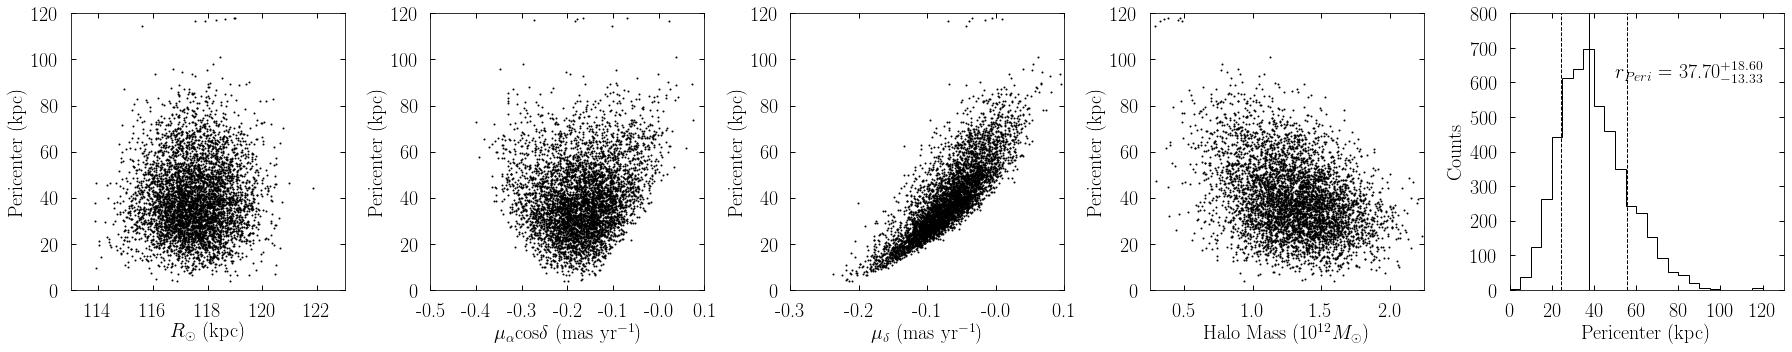

In [17]:
axesf = 20
tickf = 20

fig, ax = plt.subplots(1,5,figsize=(25,5))

ax[0].scatter(dist_ar, c10['Peri'],s=1,c='black')
ax[1].scatter(pmra_ar, c10['Peri'],s=1,c='black')
ax[2].scatter(pmde_ar, c10['Peri'],s=1,c='black')
ax[3].scatter(mass_ar, c10['Peri'],s=1, c='black') #mass is in multiple of 10^12
ax[4].hist(c10['Peri'],bins=np.arange(0,125,5), histtype='step', stacked=True, fill=False,color='black')

ax[0].set_ylim(0,120)
ax[1].set_ylim(0,120)
ax[2].set_ylim(0,120)
ax[3].set_ylim(0,120)
ax[4].set_ylim(0,800)

ax[0].set_xlim(113,123)
ax[1].set_xlim(-0.5,0.1)
ax[2].set_xlim(-0.3,0.1)
ax[3].set_xlim(0.25,2.25)
ax[4].set_xlim(0,130)

ax[4].axvline(p16val,ls='--',lw=1,color='black')
ax[4].axvline(p50val,ls='-',lw=1,color='black')
ax[4].axvline(p84val,ls='--',lw=1,color='black')

ax[0].set_xlabel(r'$R_{\odot}$ (kpc)',fontsize=axesf)
ax[1].set_xlabel(r'$\mu_{\alpha}$cos$\delta$ (mas yr$^{-1}$)',fontsize=axesf)
ax[2].set_xlabel(r'$\mu_{\delta}$ (mas yr$^{-1}$)',fontsize=axesf)
ax[3].set_xlabel(r'Halo Mass (10$^{12} M_{\odot}$)',fontsize=axesf)
ax[4].set_xlabel(r'Pericenter (kpc)',fontsize=axesf)

ax[0].set_ylabel(r'Pericenter (kpc)',fontsize=axesf)
ax[1].set_ylabel(r'Pericenter (kpc)',fontsize=axesf)
ax[2].set_ylabel(r'Pericenter (kpc)',fontsize=axesf)
ax[3].set_ylabel(r'Pericenter (kpc)',fontsize=axesf)
ax[4].set_ylabel(r'Counts',fontsize=axesf)

ax[4].text(50,600,r'$r_{Peri}$ = 37.70$^{+18.60}_{-13.33}$',fontsize=20)

major_tick_length = 5
major_tick_width = 1
minor_tick_length = 2
minor_tick_width = 1

for i in [0,1,2,3]:
    ax[i].yaxis.set_major_locator(MultipleLocator(20))
    ax[i].set_yticklabels(np.round(np.arange(-20,140,20),0),fontsize=tickf)
    ax[i].tick_params(axis='both',direction='in',bottom='on',top='on',right='on',left='on',which='major',
                 length = major_tick_length, width = major_tick_width)

ax[4].set_yticklabels(np.round(np.arange(0,900,100),0),fontsize=tickf)
ax[4].tick_params(axis='both',direction='in',bottom='on',top='on',right='on',left='on',which='major',
                 length = major_tick_length, width = major_tick_width)

ax[0].set_xticklabels(np.round(np.arange(112,124,2),0),fontsize=tickf)
ax[1].set_xticklabels(np.round(np.arange(-0.5,0.2,0.1),1),fontsize=tickf)

ax[2].xaxis.set_major_locator(MultipleLocator(.1))
ax[2].set_xticklabels(np.round(np.arange(-0.4,0.2,0.1),1),fontsize=tickf)

ax[3].xaxis.set_major_locator(MultipleLocator(0.5))
ax[3].set_xticklabels(np.round(np.arange(0,2.50,0.50),2),fontsize=tickf)
ax[4].set_xticklabels(np.round(np.arange(0,130,20),0),fontsize=tickf)

fig.tight_layout()

fig.savefig('CraIIMC_M17.pdf',dpi=dpi,
            bbox_inches='tight')

# Testing the effects of halo flattening on the pericenter distribution

In [21]:
p16 = []
p50 = []
p84 = []

df_ar = [c06,c06,c07,c08,c09,c10]

for i in range(len(df_ar)):
    perc_16 = np.percentile(df_ar[i]['Peri'],16)
    perc_50 = np.percentile(df_ar[i]['Peri'],50)
    perc_84 = np.percentile(df_ar[i]['Peri'],84)
    
    p16.append(perc_16)
    p50.append(perc_50)
    p84.append(perc_84)
        
p16 = np.array(p16)
p50 = np.array(p50)
p84 = np.array(p84)


(0, 70)

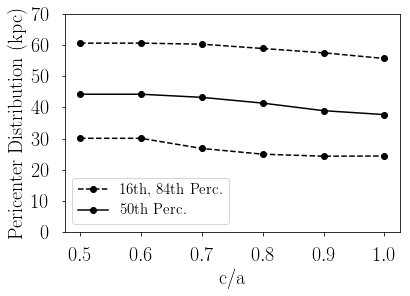

In [25]:
plt.plot(c_grid, p16,marker='o',color='black',label='16th, 84th Perc.',ls='--')
plt.plot(c_grid, p50,marker='o',color='black',label='50th Perc.',ls='-')
plt.plot(c_grid, p84,marker='o',color='black',label='',ls='--')

plt.xlabel('c/a',fontsize=20)
plt.ylabel('Pericenter Distribution (kpc)',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=15)

plt.ylim(0,70)


# Monte Carlo simulation of the pericenter distance of Crater II for different flattening parameters. The simulation folds in the uncertainty in the proper motion of Crater II, the distance of Crater II, as well as the mass of the Milky Way halo.

In [5]:
np.random.seed(4747)

sampsize = 5000

dist_ar = np.random.normal(dist, dist_err, sampsize)
pmra_ar = np.random.normal(pmra, np.sqrt(np.square(pmra_e) + np.square(gaiasys)),sampsize)
pmde_ar = np.random.normal(pmdec, np.sqrt(np.square(pmdec_e) + np.square(gaiasys)), sampsize)

mass_ar = np.random.normal(1.3, 0.3, sampsize) 
c_grid = np.array([0.5,0.6,0.7,0.8,0.9,1.0]) 

In [6]:
ts = np.linspace(0,10,10000)*u.Gyr

peri_total = np.array([])
c_total = np.array([])
tr_total = np.array([]) # only for flat halo
eccen_total = np.array([]) # only for flat halo 

for k in range(c_grid.size):
    c = c_grid[k]
    
    tp_amp= potential.TriaxialNFWPotential(amp=1.,a=2.,c=c)
    mvir= tp_amp.mass(245./ro,245./ro,ro=ro,vo=vo)/10.**12. 

    c_arr = np.empty(sampsize)
    c_arr.fill(c)
    
    c_total = np.concatenate([c_total,c_arr])
    
    peri = np.empty(sampsize)
    tr = np.empty(sampsize)
    eccen = np.empty(sampsize)
    
    for i in range(sampsize):
    
        tp= potential.TriaxialNFWPotential(amp=mass_ar[i]/mvir,a=2.,c=c) 
        
        if i % 100 == 0:
            print(k, i)

        pot = [tp,bp,mp]

        orb = Orbit([ra*u.degree,
                     dec*u.degree,
                     dist_ar[i]*u.kpc,
                     pmra_ar[i]*u.mas/u.yr,
                     pmde_ar[i]*u.mas/u.yr,
                     vlos*u.km/u.s],
                    radec=True,solarmotion='Schoenrich',ro=ro*u.kpc,vo=vo*u.km/u.s)

        orb_flip = orb.flip() 
        orb_flip.integrate(ts,pot)

        peri[i] = orb_flip.rperi()
        
        if c > 0.95:
            tr[i] = orb_flip.Tr()
            eccen[i] = orb_flip.e()
        
    if c < 0.95:
        peri_total = np.concatenate([peri_total,peri])
        tr = np.empty(sampsize)
        tr.fill(np.nan)
        eccen = np.empty(sampsize)
        eccen.fill(np.nan)
        
        eccen_total = np.concatenate([eccen_total, eccen])
        tr_total = np.concatenate([tr_total, tr])
    else:
        peri_total = np.concatenate([peri_total,peri])
        tr_total = np.concatenate([tr_total,tr])
        eccen_total = np.concatenate([eccen_total, eccen])
    

0 0
0 100
0 200
0 300
0 400
0 500
0 600
0 700
0 800
0 900
0 1000
0 1100
0 1200
0 1300
0 1400
0 1500
0 1600
0 1700
0 1800
0 1900
0 2000
0 2100
0 2200
0 2300
0 2400
0 2500
0 2600
0 2700
0 2800
0 2900
0 3000
0 3100
0 3200
0 3300
0 3400
0 3500
0 3600
0 3700
0 3800
0 3900
0 4000
0 4100
0 4200
0 4300
0 4400
0 4500
0 4600
0 4700
0 4800
0 4900
1 0
1 100
1 200
1 300
1 400
1 500
1 600
1 700
1 800
1 900
1 1000
1 1100
1 1200
1 1300
1 1400
1 1500
1 1600
1 1700
1 1800
1 1900
1 2000
1 2100
1 2200
1 2300
1 2400
1 2500
1 2600
1 2700
1 2800
1 2900
1 3000
1 3100
1 3200
1 3300
1 3400
1 3500
1 3600
1 3700
1 3800
1 3900
1 4000
1 4100
1 4200
1 4300
1 4400
1 4500
1 4600
1 4700
1 4800
1 4900
2 0
2 100
2 200
2 300
2 400
2 500
2 600
2 700
2 800
2 900
2 1000
2 1100
2 1200
2 1300
2 1400
2 1500
2 1600
2 1700
2 1800
2 1900
2 2000
2 2100
2 2200
2 2300
2 2400
2 2500
2 2600
2 2700
2 2800
2 2900
2 3000
2 3100
2 3200
2 3300
2 3400
2 3500
2 3600
2 3700
2 3800
2 3900
2 4000
2 4100
2 4200
2 4300
2 4400
2 4500
2 4600
2 4700


In [9]:
mc_res = pd.DataFrame()

mc_res['Peri'] = peri_total
mc_res['c'] = c_total
mc_res['tr'] = tr_total
mc_res['e'] = eccen_total

mc_res.to_csv('craII_peric.txt',sep=',',index=False)